Depth 1


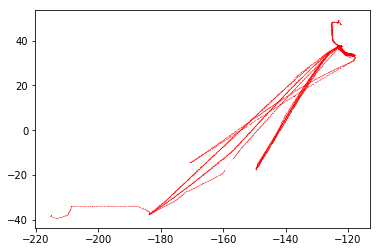

<Figure size 360x144 with 0 Axes>

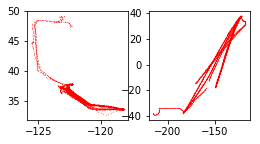

Depth 1 1번째 편차 : 169.32
Depth 1 2번째 편차 : 1232.38

Depth 2


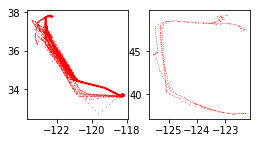

편차 : 17.98
편차 : 9.55
Depth 2


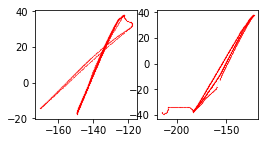

편차 : 94.09
편차 : 179.04
Depth 3


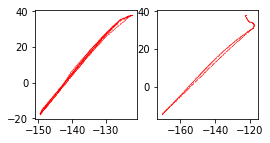

편차 : 4.51
편차 : 1.36
Depth 3


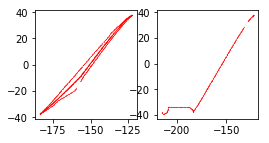

편차 : 8.97
편차 : 0.0


array(['0022222', '1220222', '1222202', '1222122', '0212222', '1222221'],
      dtype=object)

In [2]:
import datetime
import pandas as pd
import numpy as np
import folium
import sklearn
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.cluster import KMeans
from math import *    
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")                       

data = pd.read_csv('D:/SDS_project/data/1205_data.csv')
port = pd.read_csv('D:/SDS_project/data/DATA/PORT_MERGE_out.csv')
###############################################################################################################

def port_5km(data, lat, lon): # 도착지(특정 항구)를 기준으로 5km이내 모든 경로 가져오기
    data1 = data.groupby(['MMSI3']).last()
    L1 = []
    
    for i,j,k in zip(data1.index, data1['LAT'], data1['LON']):
        R = 6373.0 
        lat1 = radians(j) 
        lon1 = radians(k) 
        lat2 = radians(lat) 
        lon2 = radians(lon)
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
        c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
        distance = R * c
        L1.append(distance)

    df1 = pd.DataFrame(list(zip(data1.index, L1)), columns = ['MMSI3', 'distance'])
    df2 = df1[df1['distance'] <= 5]['MMSI3'].tolist()
    df3 = data[data['MMSI3'].isin(df2)].reset_index(drop=True)
    
    return df3

###############################################################################################################

def ten_number(data): # 각각의 배에대해서 11등분된 경로의 위도 경도 좌표
    L1 = list()
    for i, j in data.groupby('MMSI3').agg({'MMSI3': 'unique', 'MMSI': 'count'}).reset_index(drop=True).apply(lambda x: (x.MMSI3[0], x.MMSI), axis=1).tolist():
        for k in range(0, 11, 1):
            k = k/10
            df1 = data[data['MMSI3'] == i][['MMSI3', 'LAT', 'LON']].reset_index()
            
            if k == 0:
                L2 = list()
                L2.extend(list(df1[['MMSI3', 'LAT', 'LON']].iloc[0, :]))
            elif 0 < k < 1:
                L2.extend(list(df1[['LAT', 'LON']].iloc[int(round(j*k)), :]))
            else:
                L2.extend(list(df1[['LAT', 'LON']].iloc[-1, :]))
        L1.append(L2)

    L2 = pd.DataFrame(L1)
    
    
    if pd.isnull(L2).sum().sum() != 0:
        print('exist null...!!!!!')
    
    return L2

#df3 = ten_number(port_ais)

###############################################################################################################

def visualization(data, sorted_L, i):
    plt.figure(figsize=(4, 2))
    print(i)
    data3 = data
    L = sorted_L
    for i, j in enumerate(L):
        data_cluster = data3[np.array(data3.iloc[:,-1:]).tolist() == j][['MMSI3', 'LAT', 'LON']]
        L2 = data_cluster['MMSI3'].unique()
        for k in L2:
                plt.subplot(1, 2, i+1)
                plt.plot(data_cluster[data_cluster['MMSI3'] == k]['LON'], data_cluster[data_cluster['MMSI3'] == k]['LAT'], 
                         'rs--', linewidth = .1, markersize = .1)
    return plt.show()

###############################################################################################################

def mean_test(data):
    mean = data.describe().loc['mean',:]

    L = list()
    for i,j in zip(mean, data.columns):
        sum = 0
        for k in data.index:
            sum = sum + (i-data[j][k])**2
        L.append(round(sum,2))
    L1 = np.mean(L)
    
    return round(L1, 2)

###############################################################################################################

def deepen(data, ten_number_data):
    data3 = data
    
    data_depth2_1 = data3[data3['cluster']==0].reset_index(drop=True)
    data_depth2_2 = data3[data3['cluster']==1].reset_index(drop=True)

    X_depth2_1 = np.array(ten_number_data[ten_number_data[0].isin(data_depth2_1['MMSI3'].unique())].iloc[:,1:])
    X_depth2_2 = np.array(ten_number_data[ten_number_data[0].isin(data_depth2_2['MMSI3'].unique())].iloc[:,1:])

    if X_depth2_1.shape[0] > 1:
        kmeans_depth2_1 = KMeans(n_clusters=2, random_state=0).fit(X_depth2_1)
        del data_depth2_1['cluster']
        depth2_1 = pd.DataFrame({'MMSI3' : ten_number_data[ten_number_data[0].isin(data_depth2_1['MMSI3'].unique())].iloc[:,0].tolist(), 'cluster' : list(kmeans_depth2_1.labels_)})
        depth2_1_mg = pd.merge(data_depth2_1, depth2_1, how='left', on=['MMSI3'])
    else:
        depth2_1_mg = data_depth2_1
        
    if X_depth2_2.shape[0] > 1:
        kmeans_depth2_2 = KMeans(n_clusters=2, random_state=0).fit(X_depth2_2)
        del data_depth2_2['cluster']
        depth2_2 = pd.DataFrame({'MMSI3' : ten_number_data[ten_number_data[0].isin(data_depth2_2['MMSI3'].unique())].iloc[:,0].tolist(), 'cluster' : list(kmeans_depth2_2.labels_)})
        depth2_2_mg = pd.merge(data_depth2_2, depth2_2, how='left', on=['MMSI3'])
    else:
        depth2_2_mg = data_depth2_2

    return depth2_1_mg, depth2_2_mg    

###############################################################################################################

def input_calculate(data, ten_number_data):
    if len(data.cluster.unique()) == 1:
        df1 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(data.reset_index(drop=True)['MMSI3'].unique())])
        return mean_test(data=df1.groupby([0]).mean())
    
    
    if 0 in data.cluster.unique() and 1 in data.cluster.unique():
        data_depth2_1 = data[data['cluster']==0].reset_index(drop=True)
        data_depth2_2 = data[data['cluster']==1].reset_index(drop=True)
    elif 0 in data.cluster.unique():
        data_depth2_1 = data[data['cluster']==0].reset_index(drop=True)
    else:
        data_depth2_2 = data[data['cluster']==1].reset_index(drop=True)
    
    df1 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(data_depth2_1['MMSI3'].unique())])
    mean_result1 = mean_test(data=df1.groupby([0]).mean())
    df2 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(data_depth2_2['MMSI3'].unique())])
    mean_result2 = mean_test(data=df2.groupby([0]).mean())
    return mean_result1, mean_result2

###############################################################################################################

def print_do(data):
    data1 = data[0]
    data2 = data[1]
    print("편차 : {}".format(data1))
    print("편차 : {}".format(data2))
    return

###############################################################################################################

def deepen_new(data, ten_number_data):
    data['cluster'] = 1; del data['cluster']
    
    df1 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(data['MMSI3'].unique())])
    df1.rename(columns={0:'MMSI3'}, inplace=True)
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(df1.iloc[:,1:]))
    df_cluster = pd.DataFrame({'MMSI3' : df1.loc[:,'MMSI3'].tolist(), 'cluster' : list(kmeans.labels_)})
    df2 = pd.merge(data, df_cluster, how='left', on=['MMSI3'])
    
    return df2

###############################################################################################################

def kmeans_clustering_receive(port_ais_data, ten_number_data):
    
    
    # Depth 1
    df1 = deepen_new(port_ais_data, ten_number_data)
    
    df_cluster = df1[['MMSI3', 'cluster']]
    
    if df1[df1.cluster == 0].shape[0] < 2 or input_calculate(df1[df1.cluster == 0], ten_number_data) < 25:
        df_cluster = pd.merge(df_cluster, df1[df1.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
    else:
        # Depth 2
        df11 = deepen_new(df1[df1.cluster == 0], ten_number_data)
        if df11[df11.cluster == 0].shape[0] < 2 or input_calculate(df11[df11.cluster == 0], ten_number_data) < 25:
            df_cluster = pd.merge(df_cluster, df11[df11.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
        else:
            # Depth 3
            df111 = deepen_new(df11[df11.cluster == 0], ten_number_data)
            if df111[df111.cluster == 0].shape[0] < 2 or input_calculate(df111[df111.cluster == 0], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df111[df111.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            else:
                # Depth 4
                df1111 = deepen_new(df111[df111.cluster == 0], ten_number_data)
                if df1111[df1111.cluster == 0].shape[0] < 2 or input_calculate(df1111[df1111.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1111[df1111.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                else:
                    # Depth 5
                    df11111 = deepen_new(df1111[df1111.cluster == 0], ten_number_data)                                                                                            
                    if df11111[df11111.cluster == 0].shape[0] < 2 or input_calculate(df11111[df11111.cluster == 0], ten_number_data) < 25:
                        df_cluster = pd.merge(df_cluster, df11111[df11111.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        
                    if df11111[df11111.cluster == 1].shape[0] < 2 or input_calculate(df11111[df11111.cluster == 1], ten_number_data) < 25:
                        df_cluster = pd.merge(df_cluster, df11111[df11111.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    
                if df1111[df1111.cluster == 1].shape[0] < 2 or input_calculate(df1111[df1111.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1111[df1111.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                else:
                    # Depth 5
                    df11112 = deepen_new(df1111[df1111.cluster == 1], ten_number_data)                                                                                  
                    if df11112[df11112.cluster == 0].shape[0] < 2 or input_calculate(df11112[df11112.cluster == 0], ten_number_data) < 25:
                        df_cluster = pd.merge(df_cluster, df11112[df11112.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        
                    if df11112[df11112.cluster == 1].shape[0] < 2 or input_calculate(df11112[df11112.cluster == 1], ten_number_data) < 25:
                        df_cluster = pd.merge(df_cluster, df11112[df11112.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            
            if df111[df111.cluster == 1].shape[0] < 2 or input_calculate(df111[df111.cluster == 1], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df111[df111.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                
            else:
                # Depth 4
                df11122 = deepen_new(df111[df111.cluster == 1], ten_number_data)
                if df11122[df11122.cluster == 0].shape[0] < 2 or input_calculate(df11122[df11122.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df11122[df11122.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    
                if df11122[df11122.cluster == 1].shape[0] < 2 or input_calculate(df11122[df11122.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df11122[df11122.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
        
        
        if df11[df11.cluster == 1].shape[0] < 2 or input_calculate(df11[df11.cluster == 1], ten_number_data) < 25:
            df_cluster = pd.merge(df_cluster, df11[df11.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
        else:
            # Depth 3
            df112 = deepen_new(df11[df11.cluster == 1], ten_number_data)
            if df112[df112.cluster == 0].shape[0] < 2 or input_calculate(df112[df112.cluster == 0], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df112[df112.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            else:
                # Depth 4
                df1122 = deepen_new(df112[df112.cluster == 0], ten_number_data)
                if df1122[df1122.cluster == 0].shape[0] < 2 or input_calculate(df1122[df1122.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1122[df1122.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    
                if df1122[df1122.cluster == 1].shape[0] < 2 or input_calculate(df1122[df1122.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1122[df1122.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                
            if df112[df112.cluster == 1].shape[0] < 2 or input_calculate(df112[df112.cluster == 1], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df112[df112.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            
            else:
                df11242 = deepen_new(df112[df112.cluster == 1], ten_number_data)
                if df11242[df11242.cluster == 0].shape[0] < 2 or input_calculate(df11242[df11242.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df11242[df11242.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    
                if df11242[df11242.cluster == 1].shape[0] < 2 or input_calculate(df11242[df11242.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df11242[df11242.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            
    
    if df1[df1.cluster == 1].shape[0] < 2 or input_calculate(df1[df1.cluster == 1], ten_number_data) < 25:
        df_cluster = pd.merge(df_cluster, df1[df1.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
    else:
        # Depth 2
        df12 = deepen_new(df1[df1.cluster == 1], ten_number_data)
        if df12[df12.cluster == 0].shape[0] < 2 or input_calculate(df12[df12.cluster == 0], ten_number_data) < 25:
            df_cluster = pd.merge(df_cluster, df12[df12.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
        else:
            # Depth 3
            df121 = deepen_new(df12[df12.cluster == 0], ten_number_data)
            if df121[df121.cluster == 0].shape[0] < 2 or input_calculate(df121[df121.cluster == 0], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df121[df121.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            else:
                # Depth 4
                df1213 = deepen_new(df121[df121.cluster == 0], ten_number_data)
                if df1213[df1213.cluster == 0].shape[0] < 2 or input_calculate(df1213[df1213.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1213[df1213.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                
                if df1213[df1213.cluster == 1].shape[0] < 2 or input_calculate(df1213[df1213.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1213[df1213.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            
            if df121[df121.cluster == 1].shape[0] < 2 or input_calculate(df121[df121.cluster == 1], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df121[df121.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            else:
                # Depth 4
                df1242 = deepen_new(df121[df121.cluster == 1], ten_number_data)
                if df1242[df1242.cluster == 0].shape[0] < 2 or input_calculate(df1242[df1242.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1242[df1242.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                
                if df1242[df1242.cluster == 1].shape[0] < 2 or input_calculate(df1242[df1242.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1242[df1242.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            
            
        df12 = deepen_new(df1[df1.cluster == 1], ten_number_data)
        if df12[df12.cluster == 1].shape[0] < 2 or input_calculate(df12[df12.cluster == 1], ten_number_data) < 25:
            df_cluster = pd.merge(df_cluster, df12[df12.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
        else:
            # Depth 3
            df122 = deepen_new(df12[df12.cluster == 1], ten_number_data)
            if df122[df122.cluster == 0].shape[0] < 2 or input_calculate(df122[df122.cluster == 0], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df122[df122.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            else:
                # Depth 4
                df1233 = deepen_new(df122[df122.cluster == 0], ten_number_data)
                if df1233[df1233.cluster == 0].shape[0] < 2 or input_calculate(df1233[df1233.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1233[df1233.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                if df1233[df1233.cluster == 1].shape[0] < 2 or input_calculate(df1233[df1233.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1233[df1233.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                
            if df122[df122.cluster == 1].shape[0] < 2 or input_calculate(df122[df122.cluster == 1], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df122[df122.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            else:
                # Depth 4
                df1222 = deepen_new(df122[df122.cluster == 1], ten_number_data)
                if df1222[df1222.cluster == 0].shape[0] < 2 or input_calculate(df1222[df1222.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1222[df1222.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            
                if df1222[df1222.cluster == 1].shape[0] < 2 or input_calculate(df1222[df1222.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1222[df1222.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
    
    return df_cluster
           
###############################################################################################################    
                                                                                                                                                                                                 
def kmeans_clustering(port_ais_data, ten_number_data):
    df1 = port_ais_data
    df2 = ten_number_data.iloc[:,1:]
    
    df3 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(df1['MMSI3'].unique())])
    df3.rename(columns={0:'MMSI3'}, inplace=True)
    
    # MMSI3가 없는 데이터로 kmeans 실행
    kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(df2))
    
    df_mmsi3_cluster = pd.DataFrame({'MMSI3' : ten_number_data.loc[:,0].tolist(), 'cluster' : list(kmeans.labels_)})
    df4 = pd.merge(df1, df_mmsi3_cluster, how='left', on=['MMSI3'])
    
    df5 = df4[['MMSI3', 'LAT', 'LON']]
    for k in df4['MMSI3'].unique():
            plt.plot(df5[df4['MMSI3'] == k]['LON'], df5[df4['MMSI3'] == k]['LAT'], 'rs--', linewidth = .1, markersize = .1)
    
    
    # Depth 1
    plt.figure(figsize=(5, 2))
    visualization(data=df4, sorted_L=sorted(df4['cluster'].unique()), i='Depth 1')
    
    df_cluster = df4[['MMSI3', 'cluster']]
    
    input_calculate1, input_calculate2 = input_calculate(data=df4, ten_number_data=ten_number_data)
    print("Depth 1 1번째 편차 : {}".format(input_calculate1))
    print("Depth 1 2번째 편차 : {}\n".format(input_calculate2))
    
    if input_calculate1 < 25 and input_calculate2 < 25:
        # cluster이 1회성으로 사용될 경우 그냥 return한다.
        return df_cluster
    
    else:
        depth1_1_mg, depth1_2_mg = deepen(data=df4, ten_number_data=ten_number_data)
        if input_calculate1 > 25:
            visualization(data=depth1_1_mg, sorted_L=sorted(depth1_1_mg['cluster'].unique()), i='Depth 2')
            print_do(input_calculate(data=depth1_1_mg, ten_number_data=ten_number_data))
            
            if input_calculate(data=depth1_1_mg, ten_number_data=ten_number_data)[0] > 25:
                df_cluster = pd.merge(df_cluster, depth1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                depth1_1_1_mg, x = deepen(data=depth1_1_mg, ten_number_data=ten_number_data)
                visualization(data=depth1_1_1_mg, sorted_L=sorted(depth1_1_1_mg['cluster'].unique()), i='Depth 3')
                print_do(input_calculate(data=depth1_1_1_mg, ten_number_data=ten_number_data))
                
                if input_calculate(data=depth1_1_1_mg, ten_number_data=ten_number_data)[0] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    depth1_1_1_1_mg, x = deepen(data=depth1_1_1_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_1_1_mg, sorted_L=sorted(depth1_1_1_1_mg['cluster'].unique()), i='Depth 4')
                    print_do(input_calculate(data=depth1_1_1_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_1_1_1_mg, x = deepen(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_1_1_mg, sorted_L=sorted(depth1_1_1_1_1_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_1_1_mg, ten_number_data=ten_number_data))
                        
                    if input_calculate(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_1_1_2_mg = deepen(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_1_2_mg, sorted_L=sorted(depth1_1_1_1_2_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_1_2_mg, ten_number_data=ten_number_data))
                
                if input_calculate(data=depth1_1_1_mg, ten_number_data=ten_number_data)[1] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    x, depth1_1_1_2_mg = deepen(data=depth1_1_1_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_1_2_mg, sorted_L=sorted(depth1_1_1_2_mg['cluster'].unique()), i='Depth 4')
                    print_do(input_calculate(data=depth1_1_1_2_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_1_2_1_mg, x = deepen(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_2_1_mg, sorted_L=sorted(depth1_1_1_2_1_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_2_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_1_2_2_mg = deepen(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_2_2_mg, sorted_L=sorted(depth1_1_1_2_2_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_2_2_mg, ten_number_data=ten_number_data))
                    
            if input_calculate(data=depth1_1_mg, ten_number_data=ten_number_data)[1] > 25:
                df_cluster = pd.merge(df_cluster, depth1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                x, depth1_1_2_mg = deepen(data=depth1_1_mg, ten_number_data=ten_number_data)
                visualization(data=depth1_1_2_mg, sorted_L=sorted(depth1_1_2_mg['cluster'].unique()), i='Depth 3')
                print_do(input_calculate(data=depth1_1_2_mg, ten_number_data=ten_number_data))
                
                if input_calculate(data=depth1_1_2_mg, ten_number_data=ten_number_data)[0] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    depth1_1_2_1_mg, x = deepen(data=depth1_1_2_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_2_1_mg, sorted_L=sorted(depth1_1_2_1_mg['cluster'].unique()), i='Depth 4')
                    print_do(input_calculate(data=depth1_1_2_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_2_1_1_mg, x = deepen(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_1_1_mg, sorted_L=sorted(depth1_1_2_1_1_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data))
                        
                        if input_calculate(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)[0] > 25:
                            df_cluster = pd.merge(df_cluster, depth1_1_2_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                            depth1_1_2_1_1_1_mg, x = deepen(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)
                            visualization(data=depth1_1_2_1_1_1_mg, sorted_L=sorted(depth1_1_2_1_1_1_mg['cluster'].unique()), i='Depth 6')
                            print_do(input_calculate(data=depth1_1_2_1_1_1_mg, ten_number_data=ten_number_data))
                        
                        if input_calculate(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)[1] > 25:
                            df_cluster = pd.merge(df_cluster, depth1_1_2_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                            x, depth1_1_2_1_1_1_mg = deepen(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)
                            visualization(data=depth1_1_2_1_1_1_mg, sorted_L=sorted(depth1_1_2_1_1_1_mg['cluster'].unique()), i='Depth 6')
                            print_do(input_calculate(data=depth1_1_2_1_1_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_2_1_2_mg = deepen(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_1_2_mg, sorted_L=sorted(depth1_1_2_1_2_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_2_1_2_mg, ten_number_data=ten_number_data))
                
                if input_calculate(data=depth1_1_2_mg, ten_number_data=ten_number_data)[1] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    x, depth1_1_2_2_mg = deepen(data=depth1_1_2_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_2_2_mg, sorted_L=sorted(depth1_1_2_2_mg['cluster'].unique()), i='Depth 4')
                    print_do(input_calculate(data=depth1_1_2_2_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_2_2_1_mg, x = deepen(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_2_1_mg, sorted_L=sorted(depth1_1_2_2_1_mg['cluster'].unique()), i='Depth 4')
                        print_do(input_calculate(data=depth1_1_2_2_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_2_2_2_mg = deepen(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_2_mg, sorted_L=sorted(depth1_1_2_2_2_mg['cluster'].unique()), i='Depth 4')
                        print_do(input_calculate(data=depth1_1_2_2_2_mg, ten_number_data=ten_number_data))
        
        
        
        
        # rigth pruning
        if input_calculate2 > 25:
            visualization(data=depth1_2_mg, sorted_L=sorted(depth1_2_mg['cluster'].unique()), i='Depth 2')
            print_do(input_calculate(data=depth1_2_mg, ten_number_data=ten_number_data))
            
            if input_calculate(data=depth1_2_mg, ten_number_data=ten_number_data)[0] > 25:
                df_cluster = pd.merge(df_cluster, depth1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                depth1_1_1_mg, x = deepen(data=depth1_2_mg, ten_number_data=ten_number_data)
                visualization(data=depth1_1_1_mg, sorted_L=sorted(depth1_1_1_mg['cluster'].unique()), i='Depth 3')
                print_do(input_calculate(data=depth1_1_1_mg, ten_number_data=ten_number_data))
                
                if input_calculate(data=depth1_1_1_mg, ten_number_data=ten_number_data)[0] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    depth1_1_1_1_mg, x = deepen(data=depth1_1_1_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_1_1_mg, sorted_L=sorted(depth1_1_1_1_mg['cluster'].unique()), i='Depth 4')
                    print_do(input_calculate(data=depth1_1_1_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_1_1_1_mg, x = deepen(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_1_1_mg, sorted_L=sorted(depth1_1_1_1_1_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_1_1_mg, ten_number_data=ten_number_data))
                        
                    if input_calculate(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_1_1_2_mg = deepen(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_1_2_mg, sorted_L=sorted(depth1_1_1_1_2_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_1_2_mg, ten_number_data=ten_number_data))
                        
                if input_calculate(data=depth1_1_1_mg, ten_number_data=ten_number_data)[1] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    print(depth1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean())
                    x, depth1_1_1_2_mg = deepen(data=depth1_1_1_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_1_2_mg, sorted_L=sorted(depth1_1_1_2_mg['cluster'].unique()), i='Depth 4')
                    
                    if input_calculate(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_1_2_1_mg, x = deepen(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_2_1_mg, sorted_L=sorted(depth1_1_1_2_1_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_2_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_1_2_2_mg = deepen(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_2_2_mg, sorted_L=sorted(depth1_1_1_2_2_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_2_2_mg, ten_number_data=ten_number_data))
                    
            if input_calculate(data=depth1_2_mg, ten_number_data=ten_number_data)[1] > 25:
                df_cluster = pd.merge(df_cluster, depth1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                x, depth1_1_2_mg = deepen(data=depth1_2_mg, ten_number_data=ten_number_data)
                visualization(data=depth1_1_2_mg, sorted_L=sorted(depth1_1_2_mg['cluster'].unique()), i='Depth 3')
                print_do(input_calculate(data=depth1_1_2_mg, ten_number_data=ten_number_data))
                
                if input_calculate(data=depth1_1_2_mg, ten_number_data=ten_number_data)[0] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    depth1_1_2_1_mg, x = deepen(data=depth1_1_2_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_2_1_mg, sorted_L=sorted(depth1_1_2_1_mg['cluster'].unique()), i='Depth 4')
                    print_do(input_calculate(data=depth1_1_2_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_2_1_1_mg, x = deepen(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_1_1_mg, sorted_L=sorted(depth1_1_2_1_1_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data))
                        
                        if input_calculate(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)[0] > 25:
                            df_cluster = pd.merge(df_cluster, depth1_1_2_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                            depth1_1_2_1_1_1_mg, x = deepen(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)
                            visualization(data=depth1_1_2_1_1_1_mg, sorted_L=sorted(depth1_1_2_1_1_1_mg['cluster'].unique()), i='Depth 6')
                            print_do(input_calculate(data=depth1_1_2_1_1_1_mg, ten_number_data=ten_number_data))
                        
                        if input_calculate(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)[1] > 25:
                            df_cluster = pd.merge(df_cluster, depth1_1_2_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                            x, depth1_1_2_1_1_1_mg = deepen(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)
                            visualization(data=depth1_1_2_1_1_1_mg, sorted_L=sorted(depth1_1_2_1_1_1_mg['cluster'].unique()), i='Depth 6')
                            print_do(input_calculate(data=depth1_1_2_1_1_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_2_1_2_mg = deepen(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_1_2_mg, sorted_L=sorted(depth1_1_2_1_2_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_2_1_2_mg, ten_number_data=ten_number_data))
                
                if input_calculate(data=depth1_1_2_mg, ten_number_data=ten_number_data)[1] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    x, depth1_1_2_2_mg = deepen(data=depth1_1_2_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_2_2_mg, sorted_L=sorted(depth1_1_2_2_mg['cluster'].unique()), i='Depth 4')
                    print_do(input_calculate(data=depth1_1_2_2_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_2_2_1_mg, x = deepen(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_2_1_mg, sorted_L=sorted(depth1_1_2_2_1_mg['cluster'].unique()), i='Depth 4')
                        print_do(input_calculate(data=depth1_1_2_2_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_2_2_2_mg = deepen(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_2_mg, sorted_L=sorted(depth1_1_2_2_2_mg['cluster'].unique()), i='Depth 4')
                        print_do(input_calculate(data=depth1_1_2_2_2_mg, ten_number_data=ten_number_data))

                
    return

###############################################################################################################

def test_receive(cluster_data): # test데이터의 70%지점까지와 train데이터의 70%지점까지를 비교해서 가장 가까운 군집에 할당      
    data = pd.read_csv('C:/Users/renz/Desktop/1205_data.csv')
    data['LON'] = data['LON'].apply(lambda x : (x - 360) if x>0 else x )
    test = pd.concat([data, pd.DataFrame({'ETA4':data['ETA3'].apply(lambda x: x[:7].replace('-', ''))})], axis = 1).groupby('MMSI3').first().reset_index()
    test2 = test[test['ETA4'].apply(lambda x: x in ['201808', '201807'])]
    test3 = data[data['MMSI3'].isin(test2['MMSI3'])]
    train = data[data.MMSI3.isin(test3.MMSI3) == False]
    data = train
    
    train_port_ais = pd.merge(train, cluster_data, how = 'left', on = ['MMSI3']).dropna(axis = 0).reset_index(drop=True)
    test_port_ais = port_5km(data=test3, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])   
    
    train_ten_number = ten_number(train_port_ais)
    train_ten_number.rename(columns={0:'MMSI3'}, inplace=True)
    test_ten_number = ten_number(test_port_ais)
    test_ten_number.rename(columns={0:'MMSI3'}, inplace=True)
        
    train_Cluster = pd.merge(train_ten_number, train_port_ais[['MMSI3', 'Cluster']], how = 'left', on = ['MMSI3']).groupby('Cluster').mean().reset_index()
                 
    train_Cluster = pd.concat([train_Cluster.iloc[:,:17], train_Cluster.iloc[:,21:]], axis = 1)
    test_ten_number = pd.concat([test_ten_number.iloc[:,:17], test_ten_number.iloc[:,21:]], axis = 1)
    
    L = []
    for i in test_ten_number.index:
        L2 = []
        for j in train_Cluster.index:
            sum = 0
            for l1,l2 in zip(test_ten_number.iloc[i,1:], train_Cluster.iloc[j,1:]):
                sum = sum + (l1-l2)**2
            L2.append(sum)
        L.append(train_Cluster.Cluster[L2.index(min(L2))])
    test5 = pd.DataFrame({'MMSI3':test_ten_number.MMSI3, 'Cluster':L})
    
    return test5

###############################################################################################################

def train_test_set_receive(cluster_data, test_ship, Cluster):
    data = pd.read_csv('C:/Users/renz/Desktop/1205_data.csv')
    data['LON'] = data['LON'].apply(lambda x : (x - 360) if x>0 else x )
    test = pd.concat([data, pd.DataFrame({'ETA4':data['ETA3'].apply(lambda x: x[:7].replace('-', ''))})], axis = 1).groupby('MMSI3').first().reset_index()
    test2 = test[test['ETA4'].apply(lambda x: x in ['201808', '201807'])]
    test3 = data[data['MMSI3'].isin(test2['MMSI3'])]
    train = data[data.MMSI3.isin(test3.MMSI3) == False]
    data = train
    
    train_port_ais = pd.merge(train, cluster_data, how = 'left', on = ['MMSI3']).dropna(axis = 0).reset_index(drop=True)                                         
    test_port_ais = port_5km(data=test3, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])
    
    train_port_ais = train_port_ais[train_port_ais['Cluster'] == Cluster].reset_index(drop=True)
    test_port_ais = test_port_ais[test_port_ais['MMSI3'].isin(test_port_ais[test_port_ais['MMSI3'] == test_ship]['MMSI3'])].reset_index(drop=True)
    
    train = Y_Value(train_port_ais)[['MMSI3', 'LAT', 'LON', 'y_value']]
    test = Y_Value(test_port_ais)[['MMSI3', 'LAT', 'LON', 'y_value']]
    
    distance2(train)
    distance2(test)
    
    return train, test

###############################################################################################################

def distance2(data):
    df1 = data.groupby('MMSI3').last()
    
    for i,j,k in zip(df1.index, df1['LAT'], df1['LON']):
        data2 = data[data.MMSI3 == i]
        for index, l1, l2 in zip(data2.index, data2['LAT'], data2['LON']):
            R = 6373.0 
            lat1 = radians(j) 
            lon1 = radians(k) 
            lat2 = radians(l1) 
            lon2 = radians(l2) 
            dlon = lon2 - lon1 
            dlat = lat2 - lat1 
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
            c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
            distance = R * c
            data.loc[index, 'distance'] = distance
            
    return data

###############################################################################################################

def Y_Value(x) :  # 목적지까지 남은 시간 계산
    x['ETA'] = x['ETA'].astype(str).apply(lambda x: x[0:19])
    x['ETA'] = x['ETA'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M"))
    lastTime = x.groupby('MMSI3').last()['ETA'].reset_index()
    lastTime.columns = ['MMSI3','LAST_ETA']
    x = pd.merge(x, lastTime , on = 'MMSI3')
    x['y_value'] = (x['LAST_ETA'] - x['ETA']) /np.timedelta64(1, 'h')
    return x
       
#train = Y_Value(train)
#test = Y_Value(test)

###############################################################################################################
# train, test set 70% 지점 자르기 + 도착항구 (70% 지점 까지의 데이터만 가져오기) 
def y_70(data) : 
    L = []
    if len(data.MMSI3.unique()) == 1:
        for i,j in zip(data.index < int(round(max(data.index) * 0.75)), data.index == max(data.index)):
              L.append(i or j)
        return data[L]
        
    else:
        df1 = round(x.groupby('MMSI3').count().distance * 0.75).astype(int).reset_index()
        df2 = pd.DataFrame()
        for i,j in zip(df1.MMSI3, df1.distance):       
            df2 = df2.append(data[data.MMSI3 == i].reset_index().iloc[:j+1,:], ignore_index = True)
            df2 = df2.append(data[data.MMSI3 == i].reset_index().iloc[-1,:], ignore_index = True)
        return df2  
    
###############################################################################################################
     
def ten_number_for_model(data): # 70% 각 배의 분위수 지점마다의 LAT,LON,' Y_VALUE',' distance', 그리고 70% 지점에서의
                                # 남은시간 변수 만들어주기
    L1 = list()
    df2 = data.groupby('MMSI3').count().reset_index()[['MMSI3', 'distance']]

    
    for i,j in zip(df2.MMSI3, df2.distance):
        df1 = data[data['MMSI3'] == i][['MMSI3', 'LAT', 'LON']].reset_index(drop=True)
        
        if j > 6:
            for k in range(0, 11, 2):
                k = k/10
                if k == 0:
                    df1 = data[data['MMSI3'] == i][['MMSI3', 'LAT', 'LON', 'y_value', 'distance']].reset_index(drop=True)
                    L2 = list()
                    L2.extend(list(df1.iloc[0, :]))
                elif 0 < k < 1:
                    df1 = data[data['MMSI3'] == i][['LAT', 'LON', 'y_value', 'distance']].reset_index(drop=True)
                    L2.extend(list(df1.iloc[int(round(j*k)), :]))
                else:
                    df1 = data[data['MMSI3'] == i][['LAT', 'LON', 'y_value', 'distance']].reset_index(drop=True)
                    L2.extend(list(df1.iloc[-2, :]))
                    df1 = data[data['MMSI3'] == i][['LAT', 'LON']].reset_index(drop=True)
                    L2.extend(list(df1.iloc[-1, :]))
            L1.append(L2)

        L2 = pd.DataFrame(L1)
    
    
    if pd.isnull(L2).sum().sum() != 0:
        print('exist null...!!!!!')

    return L2
  
###############################################################################################################

data = pd.read_csv('C:/Users/renz/Desktop/1205_data.csv') # 배가 6시간 이상 정지해 있으면 다른경로로 간주되어 경로 분할된 데이터 (MMSI3)
data['LON'] = data['LON'].apply(lambda x : (x - 360) if x>0 else x )   

test = pd.concat([data, pd.DataFrame({'ETA4':data['ETA3'].apply(lambda x: x[:7].replace('-', ''))})], axis = 1).groupby('MMSI3').first().reset_index()
test2 = test[test['ETA4'].apply(lambda x: x in ['201808', '201807'])]
test3 = data[data['MMSI3'].isin(test2['MMSI3'])]     # 2018년 7월 또는 8월에 출발하기 시작한 배들 (testdata)
train = data[data.MMSI3.isin(test3.MMSI3) == False]  # 2015년 10월 ~ 2018년 6월 사이에 출발한 배들 (traindata)
data = train  

port = pd.read_csv('C:/Users/renz/Desktop/PORT_MERGE_out.csv') # 항구 데이터

###############################################################################################################
# 배들이 가장 많이 방문한 항구 찾아내기

df1 = data.groupby('MMSI3').last()
L2 = []
for i,j,k in zip(df1.index, df1['LAT'], df1['LON']):
    L1 = []
    for l1, l2 in zip(port['LAT'], port['LON']):
        R = 6373.0 
        lat1 = radians(j) 
        lon1 = radians(k) 
        lat2 = radians(l1) 
        lon2 = radians(l2) 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
        c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
        distance = R * c
        L1.append(distance)
    L2.append([min(L1), port.iloc[L1.index(min(L1)),0], port.iloc[L1.index(min(L1)),1], port.iloc[L1.index(min(L1)),2]])
   #l2 -> 각각의 배가 방문한 항구의 이름과 위경도 좌표
    
port_count = pd.DataFrame(L2, columns = ['distance', 'port_id', 'LAT', 'LON']).reset_index(drop=True).groupby('port_id').agg({'distance':'count', 'LAT':'mean', 'LON':'mean'}).reset_index().sort_values(by='distance', ascending=False)
df2 = port_count[port_count.port_id.isin(['USOAK', 'USLGB', 'KRPUS', 'JPSHS', 'MXZLO', 'CNYTN'])].reset_index(drop=False)

###############################################################################################################

port_id = 'USOAK'
port_ais = port_5km(data=data, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])
df3 = ten_number(port_ais)
kmeans_clustering(port_ais_data=port_ais, ten_number_data=df3)

cluster_data = kmeans_clustering_receive(port_ais_data=port_ais, ten_number_data=df3)
cluster_data = pd.concat([cluster_data.fillna(2).groupby('MMSI3').mean().reset_index().MMSI3, cluster_data.fillna(2).groupby('MMSI3').mean().reset_index().iloc[:,1:].apply(lambda x: ''.join(x.astype(int).astype(str)), axis=1)], axis=1)
cluster_data.rename(columns={0:'Cluster'}, inplace=True)
cluster_data.Cluster.unique()



In [4]:
cluster_data.Cluster.unique()

array(['0022222', '1220222', '1222202', '1222122', '0212222', '1222221'],
      dtype=object)

In [12]:
a[a['Cluster'] ==  '0022222']

,ETA,ETA2,MMSI,LAT,LON,SPEED,DATE_DIFF,CASE_DIFF,CUM_SUM,MMSI2,ETA3,HOUR_NUM,HOUR_DIFF,HOUR_DIFF2,HOUR_DIFF3,HOUR_DIFF4,MMSI3,Cluster
0,2016-05-01 1:54,2016-04-29 16:50,210000000.0,33.7575,-118.2610,2,2.0,1,13,210161000_13,2016-05-01 01,1,1 days 09:03:39.000000000,9,1,1,210161000_13_1,0022222
1,2016-05-01 2:00,2016-05-01 1:58,210000000.0,33.7539,-118.2648,3,0.0,0,13,210161000_13,2016-05-01 02,1,0 days 00:01:35.000000000,0,0,1,210161000_13_1,0022222
2,2016-05-01 3:03,2016-05-01 2:55,210000000.0,33.6691,-118.2500,10,0.0,0,13,210161000_13,2016-05-01 03,1,0 days 00:08:16.000000000,0,0,1,210161000_13_1,0022222
3,2016-05-01 4:04,2016-05-01 3:48,210000000.0,33.6837,-118.4454,11,0.0,0,13,210161000_13,2016-05-01 04,1,0 days 00:15:20.000000000,0,0,1,210161000_13_1,0022222
4,2016-05-01 5:01,2016-05-01 4:50,210000000.0,33.7770,-118.6326,11,0.0,0,13,210161000_13,2016-05-01 05,1,0 days 00:11:05.000000000,0,0,1,210161000_13_1,0022222
5,2016-05-01 6:06,2016-05-01 5:59,210000000.0,33.8894,-118.8618,13,0.0,0,13,210161000_13,2016-05-01 06,1,0 days 00:07:28.000000000,0,0,1,210161000_13_1,0022222
6,2016-05-01 7:05,2016-05-01 6:53,210000000.0,33.9839,-119.0746,12,0.0,0,13,210161000_13,2016-05-01 07,1,0 days 00:12:10.000000000,0,0,1,210161000_13_1,0022222
7,2016-05-01 8:08,2016-05-01 7:53,210000000.0,34.0870,-119.3039,13,0.0,0,13,210161000_13,2016-05-01 08,1,0 days 00:15:31.000000000,0,0,1,210161000_13_1,0022222
8,2016-05-01 9:02,2016-05-01 8:56,210000000.0,34.1351,-119.5206,13,0.0,0,13,210161000_13,2016-05-01 09,1,0 days 00:05:51.000000000,0,0,1,210161000_13_1,0022222
9,2016-05-01 10:01,2016-05-01 9:56,210000000.0,34.1886,-119.7601,12,0.0,0,13,210161000_13,2016-05-01 10,1,0 days 00:05:11.000000000,0,0,1,210161000_13_1,0022222


In [15]:
a = pd.merge(data , cluster_data , on = 'MMSI3')
b = a[a['Cluster'] ==  '0022222']

map = folium.Map(location = [18.29, -169.52], zoom_start=3, tiles='Stamen Terrain')
a['LON'] =a['LON'].apply(lambda x : (x - 360) if x>0 else x ) 

for i in range(len(b)) :
             folium.CircleMarker(location=[b.iloc[i,3], b.iloc[i,4]], radius=0.05,
                        color='red', fill_color='red').add_to(map) 
map.save('C:/Users/renz/Desktop/red.html')   

In [80]:
test_receive(cluster_data)   
x,y = train_test_set_receive(cluster_data, '372319000_51_3', '00222222222222')       

x1 = y_70(x)           
 
y1 = y_70(y)[['MMSI3', 'LAT', 'LON', 'y_value', 'distance']]

train_x = ten_number_for_model(x1).drop([0,23], axis=1)                                             
train_y = ten_number_for_model(x1)[23] 
test_x = ten_number_for_model(y1).drop([0,23], axis=1)   

map = folium.Map(location = [18.29, -169.52], zoom_start=3, tiles='Stamen Terrain')
#data['LON'] =data['LON'].apply(lambda x : (x - 360) if x>0 else x ) 

for i in range(len(x)) :
             folium.CircleMarker(location=[x.iloc[i,1], x.iloc[i,2]], radius=0.05,
                        color='#0080bb', fill_color='#0080bb').add_to(map) 
for i in range(170) :        
              folium.CircleMarker(location=[y.iloc[i,1], y.iloc[i,2]], radius=0.5,
                        color='red', fill_color='#0080bb').add_to(map) 
map.save('C:/Users/renz/Desktop/a.html') 

In [189]:
def y_70(data) : 
    L = []
    if len(data.MMSI3.unique()) == 1:
        for i,j in zip(data.index < int(round(max(data.index) * 0.60)), data.index == max(data.index)):
              L.append(i or j)
        return data[L]
        
    else:
        df1 = round(x.groupby('MMSI3').count().distance * 0.60).astype(int).reset_index()
        df2 = pd.DataFrame()
        for i,j in zip(df1.MMSI3, df1.distance):       
            df2 = df2.append(data[data.MMSI3 == i].reset_index().iloc[:j+1,:], ignore_index = True)
            df2 = df2.append(data[data.MMSI3 == i].reset_index().iloc[-1,:], ignore_index = True)
        return df2  
    
for i in range(len(y_70(x))) :        
              folium.CircleMarker(location=[y_70(x).loc[i,'LAT'], y_70(x).loc[i,'LON']], radius=0.05,
                        color='#0080bb', fill_color='#0080bb').add_to(map) 
        
map.save('C:/Users/renz/Desktop/abcd.html')  

In [171]:
cluster_data 
test_receive(cluster_data)  
    
x,y = train_test_set_receive(cluster_data, '372319000_51_3', '00222222222222')       

x1 = y_70(x)           

y1 = y_70(y)[['MMSI3', 'LAT', 'LON', 'y_value', 'distance']]

train_x = ten_number_for_model(x1).drop([0,23], axis=1)                                             
train_y = ten_number_for_model(x1)[23] 
test_x = ten_number_for_model(y1).drop([0,23], axis=1) 



x['MMSI'] = x['MMSI3'].apply(lambda x : x[:9])          
a =  ten_number(x)

map = folium.Map(location = [18.29, -169.52], zoom_start=3, tiles='Stamen Terrain')
#data['LON'] =data['LON'].apply(lambda x : (x - 360) if x>0 else x ) 

for i in range(len(a)) :
      for j in range(1,22) :
            folium.CircleMarker(location=[a .iloc[i,j], a .iloc[i,j+1]], radius=0.05,
                    color='blue', fill_color='#0080bb').add_to(map) 
            
for j in range(1,22) :
            folium.CircleMarker(location=[a .iloc[3,j], a .iloc[3,j+1]], radius=0.05,
                    color='green', fill_color='#0080bb').add_to(map)  
            
            
for i in range(round(len(y)*0.7)) :        
              folium.CircleMarker(location=[y.iloc[i,1], y.iloc[i,2]], radius=0.05,
                        color='red', fill_color='#0080bb').add_to(map) 
        
 
        
map.save('C:/Users/renz/Desktop/a.html')  


In [111]:
a = pd.merge( data , cluster_data, on = 'MMSI3')

In [127]:
a['color'] = a['Cluster'].apply(lambda x : 'red' if x == '02222212222222' else 'blue' )

In [130]:
map = folium.Map(location = [18.29, -169.52], zoom_start=3, tiles='Stamen Terrain')
    #data['LON'] =data['LON'].apply(lambda x : (x - 360) if x>0 else x ) 

for i in range(len(a)) :
            folium.CircleMarker(location=[a.loc[i,'LAT'], a.loc[i,'LON']], radius=1,
                    color = a.loc[i,'color'] , fill_color=a.loc[i,'color']).add_to(map) 
        
map.save('C:/Users/renz/Desktop/B.html')         

In [203]:
cluster_data 
test_receive(cluster_data)  
    
x,y = train_test_set_receive(cluster_data, '372319000_51_3', '00222222222222')       

x1 = y_70(x)           

y1 = y_70(y)[['MMSI3', 'LAT', 'LON', 'y_value', 'distance']]

train_x = ten_number_for_model(x1).drop([0,23], axis=1)                                             
train_y = ten_number_for_model(x1)[23] 
test_x = ten_number_for_model(y1).drop([0,23], axis=1) 



x['MMSI'] = x['MMSI3'].apply(lambda x : x[:9])          
a =  ten_number(x)



###

def y_70(data) : 
    L = []
    if len(data.MMSI3.unique()) == 1:
        for i,j in zip(data.index < int(round(max(data.index) * 0.60)), data.index == max(data.index)):
              L.append(i or j)
        return data[L]
        
    else:
        df1 = round(x.groupby('MMSI3').count().distance * 0.60).astype(int).reset_index()
        df2 = pd.DataFrame()
        for i,j in zip(df1.MMSI3, df1.distance):       
            df2 = df2.append(data[data.MMSI3 == i].reset_index().iloc[:j+1,:], ignore_index = True)
            df2 = df2.append(data[data.MMSI3 == i].reset_index().iloc[-1,:], ignore_index = True)
        return df2  
    
    
b = y_70(x)    
b = ten_number(b)
map = folium.Map(location = [18.29, -169.52], zoom_start=3, tiles='Stamen Terrain')
    #data['LON'] =data['LON'].apply(lambda x : (x - 360) if x>0 else x ) 

#for i in range(len(b)) :        
#              folium.CircleMarker(location=[b.loc[i,'LAT'], b.loc[i,'LON']], radius=0.05,
#                        color='#0080bb', fill_color='#0080bb').add_to(map) 
        
for i in range(len(b)) :
      for j in range(1,22) :
            folium.CircleMarker(location=[b.iloc[i,j], b.iloc[i,j+1]], radius=0.05,
                    color='#0080bb', fill_color='#0080bb').add_to(map)         
a = y_70(x)    
a = ten_number(a)        

        
for j in range(1,22) :
            folium.CircleMarker(location=[a.iloc[3,j], a.iloc[3,j+1]], radius=0.05,
                    color='green', fill_color='#0080bb').add_to(map)          
        
        
for i in range(round(len(y)*0.7)) :        
              folium.CircleMarker(location=[y.iloc[i,1], y.iloc[i,2]], radius=0.05,
                        color='red', fill_color='#0080bb').add_to(map) 
                
        
map.save('C:/Users/renz/Desktop/green.html')  

# prediction

In [ ]:
port_id = 'MXZLO'
port_ais = port_5km(data=data, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])
df3 = ten_number(port_ais)
kmeans_clustering(port_ais_data=port_ais, ten_number_data=df3)

cluster_data = kmeans_clustering_receive(port_ais_data=port_ais, ten_number_data=df3)
cluster_data = pd.concat([cluster_data.fillna(2).groupby('MMSI3').mean().reset_index().MMSI3, cluster_data.fillna(2).groupby('MMSI3').mean().reset_index().iloc[:,1:].apply(lambda x: ''.join(x.astype(int).astype(str)), axis=1)], axis=1)
cluster_data.rename(columns={0:'Cluster'}, inplace=True)
cluster_data.Cluster.unique()

cluster_data[cluster_data.Cluster=='02222022222']

test_receive(cluster_data)

x,y = train_test_set_receive(cluster_data, '477157700_6_2', '02222022222')
x1 = y_70(x)

# true_y = y_70(y).loc[y_70(y).index.tolist().index(max(y_70(y).index.tolist()))-1,'y_value']
y1 = y_70(y)[['MMSI3', 'LAT', 'LON', 'y_value', 'distance']]

train_x = ten_number_for_model(x1).drop([0,23], axis=1); train_y = ten_number_for_model(x1)[23]

y1['y_value'] = y1['y_value'].apply(lambda x: x * randrange(9000000, 11000000)/10000000)

test_x = ten_number_for_model(y1).drop([0, 23], axis=1); test_y = ten_number_for_model(y1)[23]

In [ ]:
###############################################################################################################
# 모델링 및 예측 (다중 선형 회귀 분석)
reg = LinearRegression()
reg.fit(train_x, train_y)
y_pred = reg.predict(test_x)
abs(y_pred - test_y)
###############################################################################################################

###############################################################################################################
# create dataset for lightgbm
lgb_train = lgb.Dataset(train_x, train_y)
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 10,
    'learning_rate': 0.05,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'min_child_samples' : 1,
    'verbose': 0
    
}
gbm = lgb.train(params, lgb_train, num_boost_round=119)
# predict
y_pred = gbm.predict(test_x, num_iteration=gbm.best_iteration)
abs(y_pred-test_y)
###############################################################################################################

###############################################################################################################
# 모델링 및 예측 (xgboost)
y_pred = xgb.XGBRegressor(booster='gblinear', eta = 10, min_child_weight =22,
                          max_depth = 8, gamma = 100 , alpha = 0.1, n_estimators=10000).fit(train_x, train_y).predict(test_x)

abs(test_y-y_pred)
###############################################################################################################

y_pred = RandomForestRegressor(n_estimators = 100).fit(train_x, train_y).predict(test_x)

predict_result = pd.DataFrame()
df_reg = pd.DataFrame()
df_xg = pd.DataFrame()
df_rf = pd.DataFrame()


for i in df2['port_id']:
    port_id = i
    port_ais = port_5km(data=data, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])
    df3 = ten_number(port_ais)
#     kmeans_clustering(port_ais_data=port_ais, ten_number_data=df3)
    cluster_data = kmeans_clustering_receive(port_ais_data=port_ais, ten_number_data=df3)
    cluster_data = pd.concat([cluster_data.fillna(2).groupby('MMSI3').mean().reset_index().MMSI3, cluster_data.fillna(2).groupby('MMSI3').mean().reset_index().iloc[:,1:].apply(lambda x: ''.join(x.astype(int).astype(str)), axis=1)], axis=1)
    cluster_data.rename(columns={0:'Cluster'}, inplace=True)

#         cluster_data.Cluster.unique()

    df1 = test_receive(cluster_data)

    for j1, j2 in zip(df1['MMSI3'], df1['Cluster']):
        x,y = train_test_set_receive(cluster_data, j1, j2)
        x1 = y_70(x)
        y1 = y_70(y)[['MMSI3', 'LAT', 'LON', 'y_value', 'distance']]
        train_x = ten_number_for_model(x1).drop([0,23], axis=1); train_y = ten_number_for_model(x1)[23]
        y1['y_value'] = y1['y_value'].apply(lambda x: x * randrange(9000000, 11000000)/10000000)
        test_x = ten_number_for_model(y1).drop([0, 23], axis=1); test_y = ten_number_for_model(y1)[23]
        
        train_x.columns = ['LAT11','LON12','arrive_time13','distance14',  'LAT21','LON22','arrive_time23','distance24', 'LAT31','LON32','arrive_time33','distance34', 'LAT41','LON42','arrive_time43','distance44', 'LAT51','LON52','arrive_time53','distance54', 'LAT61','LON62','distance64', 'LAT71','LON72']
        test_x.columns = ['LAT11','LON12','arrive_time13','distance14',  'LAT21','LON22','arrive_time23','distance24', 'LAT31','LON32','arrive_time33','distance34', 'LAT41','LON42','arrive_time43','distance44', 'LAT51','LON52','arrive_time53','distance54', 'LAT61','LON62','distance64', 'LAT71','LON72']
        
        train_x = train_x.loc[:,['LAT11','LON12','LAT21','LON22', 'LAT31','LON32', 'LAT41','LON42', 'LAT51','LON52', 'LAT61','LON62', 'LAT71','LON72']]
        test_x = test_x.loc[:,['LAT11','LON12','LAT21','LON22', 'LAT31','LON32', 'LAT41','LON42', 'LAT51','LON52', 'LAT61','LON62', 'LAT71','LON72']]
    
        
        # Regression
        reg = LinearRegression()
        reg.fit(train_x, train_y)
        y_pred = reg.predict(test_x)
        error1 =  test_y - y_pred
        
        df_reg = pd.concat([df_reg, pd.DataFrame(reg.coef_)], axis=1)

        
        
        try:
            # create dataset for lightgbm
            lgb_train = lgb.Dataset(train_x, train_y)
            # specify your configurations as a dict
            params = {
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': {'l2', 'l1'},
                'num_leaves': 10,
                'learning_rate': 0.05,
                'feature_fraction': 0.3,
                'bagging_fraction': 0.5,
                'bagging_freq': 5,
                'min_child_samples' : 1,
                'min_data_in_bin' : 1,
                'verbose': 0

            }
            gbm = lgb.train(params, lgb_train, num_boost_round=119)
            # predict
            y_pred = gbm.predict(test_x, num_iteration=gbm.best_iteration)
            error2 = test_y - y_pred
        except:
            error2 = 'small data'

        # 모델링 및 예측 (xgboost)
        y_pred = xgb.XGBRegressor(booster='gblinear', eta = 10, min_child_weight =22,
                                  max_depth = 8, gamma = 100 , alpha = 0.1, n_estimators=10000).fit(train_x, train_y).predict(test_x)
        error3 = test_y-y_pred
        
        df_xg = pd.concat([df_xg, pd.DataFrame(xgb.XGBRegressor(booster='gblinear', eta = 10, min_child_weight =22,
                                  max_depth = 8, gamma = 100 , alpha = 0.1, n_estimators=10000).fit(train_x, train_y).coef_)], axis=1)
        
        # random forest
        y_pred = RandomForestRegressor(n_estimators = 100).fit(train_x, train_y).predict(test_x)

        error4 = test_y-y_pred
        df_rf = pd.concat([df_rf, pd.DataFrame(RandomForestRegressor(n_estimators = 100).fit(train_x, train_y).feature_importances_)], axis=1)
        
        
        predict_result = pd.concat([predict_result, pd.DataFrame([i, j1, j2, error1, error2, error3, error4])], axis=1)